**Write the names of all group members (max. 5 members)**:
- Nils, Johnson
- Matteo, Bodmer
- Jonas, Isler
- Lucas, Gimeno
- Hai-Yen, Van

When submitting your work, please follow closely the template below.

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

![Proof](1_a_proof.JPG)

### Question 1.b - Generate dataset

In [75]:
def data_gen(N,S0,T,Sigma,paths):

    # time step
    dt = T/N

    # Generate Gaussian random variables: shape (paths, N)
    Z = torch.randn(paths, N)

    # initialize Matrix for paths
    S = torch.zeros(paths,N+1)
    S[:,0] = S0

    for i in range(N):

        S[:,i+1] = S[:,i]*torch.exp(-Sigma**2/2 * dt + Sigma*torch.sqrt(torch.tensor(dt))*Z[:,i])
    
    return S

# Generate the training set
n = 30
s0 = 1
t = 30/365
sigma = 0.5
paths_training = 100000

train = data_gen(n,s0,t,sigma,paths_training)

dataset_train = TensorDataset(train)

# Generate the test set
paths_test = 10000

test = data_gen(n,s0,t,sigma,paths_test)

dataset_test = TensorDataset(test)

### Question 1.c - Model implementation

In [76]:
# Implement the deep hedging model

# number of NN 
N = 30

# Number of neurons in hidden layers
nh1 = 32 # first hidden layer
nh2 = 32 # second hidden layer

# N number of NN
networks = nn.ModuleList([
    nn.Sequential(
        nn.Linear(1, nh1),
        nn.ReLU(),
        nn.Linear(nh1, nh2),
        nn.ReLU(),
        nn.Linear(nh2, 1)
    )
    for _ in range(N)
])

### Question 1.d - Model training

  0%|          | 0/100 [00:00<?, ?it/s]

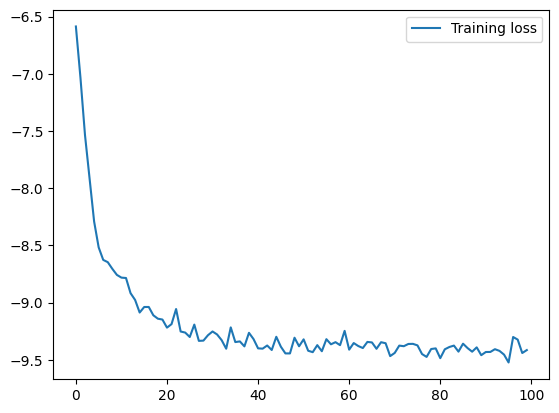

In [77]:
# Implement the payoff function of a call option
def call_payoff(ST):
    K = 1
    return torch.clamp(ST-K,min=0.0)

# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
def call_value(St,t):
    
    K = 1
    T = 30/365
    sigma = 0.5
    r = 0

    d_plus = 1/(sigma*torch.sqrt(torch.tensor(T-t))) * (torch.log(St/K)+(r + sigma**2/2)*(T-t))
    d_minus = d_plus - sigma*torch.sqrt(torch.tensor((T-t)))
    
    normal = torch.distributions.Normal(0, 1)

    value = normal.cdf(d_plus)*St - normal.cdf(d_minus)*K*torch.exp(torch.tensor(-r*(T-t)))

    return value

rn_price = call_value(train[:, 0], 0.0)

# Train the model

# Define training hyperparameters
n_epochs = 100
lr = 1e-3 # learning rate
batch_size = 1000
milestones = [75]

# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
optimizer = torch.optim.AdamW(networks.parameters(), lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

# Create a batch loader from the dataset
loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

### Training

# Computes ∑ H_tj(S_tj) * (S_{t_{j+1}} - S_{t_j})
def hedge_sum(networks, S):
    hedge = torch.zeros(S.shape[0])
    for j, net in enumerate(networks):
        Hj = net(S[:, j].unsqueeze(1)).squeeze()  # Hedge ratio for all paths
        hedge += Hj * (S[:, j+1] - S[:, j])
    return hedge

# computes loss function
def loss_fn(networks,S,rn_price):
    payoff = call_payoff(S[:,-1])
    hedge_val = hedge_sum(networks,S)
    return torch.mean((payoff-rn_price-hedge_val)**2)


losses = torch.empty(n_epochs)
training_loop = tqdm(range(n_epochs)) 

for epoch in training_loop:
    
    # At each epoch iterate over batches
    for (batch,) in loader:
        # compute training loss on batch
        loss = loss_fn(networks, batch, rn_price.mean())
        # compute gradient of training loss wrt parameters
        loss.backward()
        # do one gradient step
        optimizer.step()
        # reset the computational graph        
        optimizer.zero_grad()
        
    
    # Print loss in the progression bar
    training_loop.set_postfix(loss = loss.item())
    
    # decrease learning rate according to scheduler's settings
    scheduler.step()

    # save training loss for plotting
    losses[epoch] = loss.item()

plt.plot(torch.log(losses), label='Training loss')
plt.legend()
plt.show()

### Question 1.e - Model evaluation

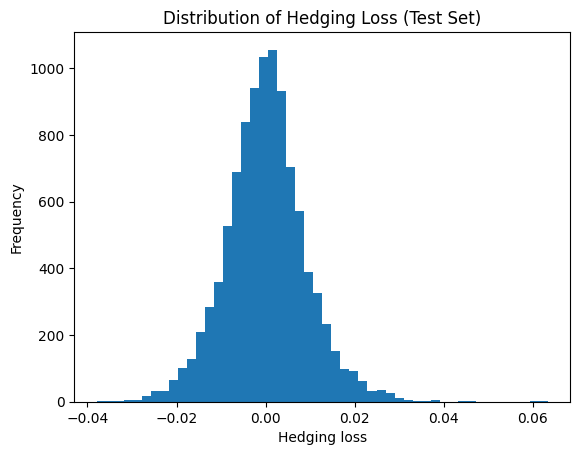

Mean hedging loss: 0.000166
Std of hedging loss: 0.009016
Mean squared hedging loss: 0.000081


In [78]:
# Evaluate the hedging losses on the test set
def pathwise_loss(networks, S, rn_price):
    payoff = call_payoff(S[:, -1])
    hedge_val = hedge_sum(networks, S)
    return payoff - rn_price - hedge_val

# turn off gradient tracking for evaluation
with torch.no_grad():
    # vector with one error per simulated path
    errors = pathwise_loss(networks, test, rn_price.mean()) 
    losses_test = errors**2

# Plot a histogram of the hedging losses and print mean and standard deviation
plt.hist(errors.numpy(), bins=50)
plt.title("Distribution of Hedging Loss (Test Set)")
plt.xlabel("Hedging loss")
plt.ylabel("Frequency")
plt.show()

# Compute mean and std of squared loss
print(f"Mean hedging loss: {errors.mean().item():.6f}")
print(f"Std of hedging loss: {errors.std().item():.6f}")
print(f"Mean squared hedging loss: {losses_test.mean().item():.6f}")

### Question 1.f(i) - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \ldots
\end{align*}

No points for solutions without explicit derivation.

![Proof](1_f_derivation.JPG)

### Question 1.f(ii) - Losses comparison with analytical solution

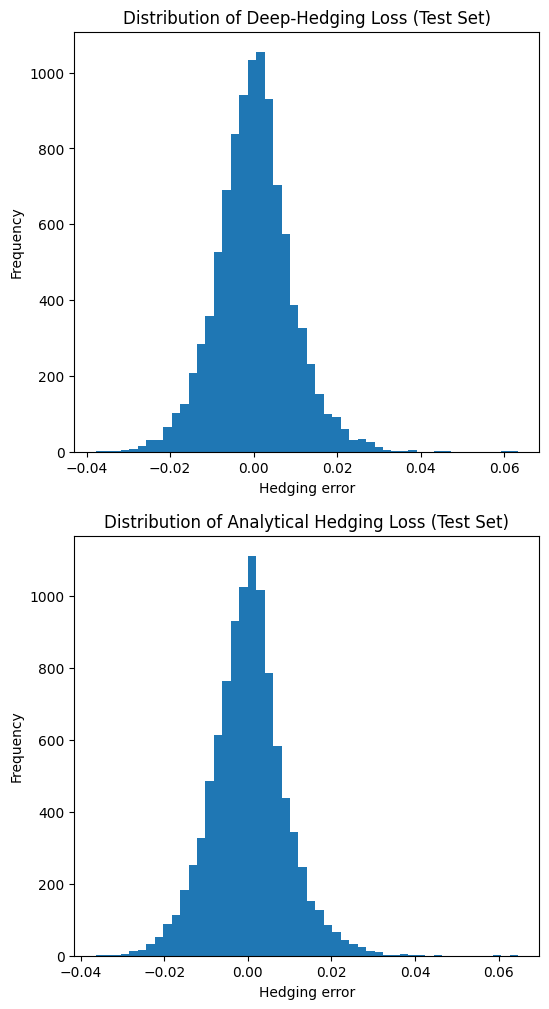

Mean deep hedging error: 0.000166
Std of deep hedging error: 0.009016
Mean analytical hedging error: 0.000171
Std of analytical hedging error: 0.008911


In [79]:
# Implement the formula you found
def analytical_hedge(n):

    K = 1
    T = 30/365
    sigma = 0.5
    r = 0

    h_bs = []
    for t in range(n):
        tau = T * (1 - t / n)
        d_plus = 1/(sigma*torch.sqrt(torch.tensor(tau))) * (torch.log(test[:,t]/K)+(r + sigma**2/2)*(tau))
        h_bs.append(torch.distributions.Normal(0, 1).cdf(d_plus))
    
    # convert tensor so that each row is one simulated path and the columns correspond to the timesteps.
    h_bs = torch.stack(h_bs, dim=1)
    
    return h_bs

def analytical_loss(H_BS, S, price):
    payoff = call_payoff(S[:, -1])
    hedge_val = torch.sum(H_BS * (S[:, 1:] - S[:, :-1]), dim=1)
    return payoff - price - hedge_val

# Evaluate the losses of the analytical hedging strategies on the test set
H_BS = analytical_hedge(N)

with torch.no_grad():
    loss_analytical = analytical_loss(H_BS, test, rn_price.mean())
# Plot a histograms of the hedging losses (analytical and deep hedging) and print means and standard deviations

fig, axes = plt.subplots(2,1,figsize=(6, 12))

# Plot a histogram of the hedging losses and print mean and standard deviation
axes[0].hist(errors.numpy(), bins=50)
axes[0].set_title("Distribution of Deep-Hedging Loss (Test Set)")
axes[0].set_xlabel("Hedging error")
axes[0].set_ylabel("Frequency")

axes[1].hist(loss_analytical.numpy(), bins=50)
axes[1].set_title("Distribution of Analytical Hedging Loss (Test Set)")
axes[1].set_xlabel("Hedging error")
axes[1].set_ylabel("Frequency")

plt.show()

# Compute mean and std of squared loss
print(f"Mean deep hedging error: {errors.mean().item():.6f}")
print(f"Std of deep hedging error: {errors.std().item():.6f}")

print(f"Mean analytical hedging error: {loss_analytical.mean().item():.6f}")
print(f"Std of analytical hedging error: {loss_analytical.std().item():.6f}")


How does your deep hedging model compare with the analytical solution? If it's worse, you must improve its performance. A few questions for you to consider...

Have you trained your deep hedging model well?
- Are the losses centered on zero? ($10^{-5} \approx 0$)
- Is their standard deviation comparable with that of the analytical solution?

How can you improve performance?
- train for more epochs
- try a different learning rate
- change the networks' architectures (first try more hidden neurons, then try more hidden layers)
- try different batch sizes
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function (e.g. $\tanh$)
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

### Question 1.g - Learned strategy comparison with analytical solution

In [1]:
# Plot both the deep hedging strategies and the analytical hedging strategies

- For what times $t_j$ are the two functions most similar? 
- Why?

# Exercise 2

### Question 2.a - Generate dataset

In [4]:
# Write function to sample V
# Write function to sample S

# Generate the training set
# Generate the test set

### Question 2.b - Model implementation

In [2]:
# Implement the deep hedging model for a generic alpha

### Question 2.c - Model training

In [4]:
# Train two deep hedging models (for alpha=0.5 and alpha=0.99) for the call option

### Question 2.d - Price comparison

In [9]:
# Print the prices p for alpha=0.5 and alpha=0.99
# Which one is higher? Why? 

### Question 2.e - Price comparison

In [ ]:
# Plot a histograms of the hedging losses (for alpha=0.5 and alpha=0.99) and print means and standard deviations